## **프로젝트 소개**
본 프로젝트는 **공공기관의 입찰 제안요청서(RFP)**를 대상으로, 자연어 처리(NLP)와 대규모 언어모델(LLM)을 활용한 **RAG 기반 문서 분석 시스템**을 구축하는 것을 목표로 한다.

입찰 RFP 문서는 수십 페이지에 달하는 복잡한 형식을 가지고 있으며, 그로 인해 컨설턴트나 기업 담당자가 핵심 정보를 빠르게 파악하는 데 어려움을 겪는다. 이에 따라, 본 프로젝트에서는 다량의 입찰 문서로부터 주요 정보(발주 기관, 사업명, 예산, 제출 방법 등)를 자동으로 추출하고 요약하며, 사용자 질의에 실시간으로 응답할 수 있는 Q&A 시스템을 개발한다.

궁극적으로 본 시스템은, 입찰 준비 과정에서의 정보 탐색 비용을 줄이고, 보다 효율적이고 정밀한 입찰 전략 수립을 지원하는 것을 목적으로 한다.

## **모듈 가져오기**

In [2]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 58.2 MB/s eta 0:00:00


In [3]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.7 MB/s eta 0:00:00


In [33]:
!apt-get -qq install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [4]:
from google.colab import files
import zipfile
import pandas as pd
import os
import fitz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import koreanize_matplotlib
import matplotlib.ticker as ticker
from wordcloud import WordCloud
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## **데이터 로드**

In [5]:
# 파일 업로드
uploaded = files.upload()

Saving data.zip to data.zip
Saving data_list.csv to data_list.csv


In [6]:
# 압축 해제
for fn in uploaded.keys():
    if fn.endswith('.zip'):
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall('./data')
        print(f"압축 해제 완료: {fn}")

압축 해제 완료: data.zip


In [8]:
file_list = os.listdir('./data')
print(f"총 파일 수: {len(file_list)}")
print("샘플 파일 5개:", file_list[:5])

총 파일 수: 100
샘플 파일 5개: ['대검찰청_아태 사이버범죄 역량강화 허브(APC-HUB) 홈페이지 및 온라인 교.hwp', '한국연구재단_2024년 대학산학협력활동 실태조사 시스템(UICC) 기능개선.hwp', '한국교육과정평가원_국가교육과정정보센터(NCIC) 시스템 운영 및 개선.hwp', '고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf', '한국전기안전공사_전기안전 관제시스템 보안 모듈 개발 용역.hwp']


## **데이터 탐색**

### **유용해 보이는 메타데이터**
- **사업 금액**
 - 사업 규모를 파악하고, 입찰 우선순위 또는 필터링 기준으로 활용 가능
 - 금액 분포나 로그스케일 분석을 통해 예산 수준 분포 파악

- **발주 기관**
 - 어떤 기관에서 입찰을 자주 내는지 분석 가능
 - 기관별 요구 사항이나 선호 패턴 파악에 기초 정보 제공

- **공개 일자 / 입찰 참여 시작일 / 입찰 참여 마감일**
 - 입찰 시점의 흐름을 파악해 시즌성 분석 가능
 - 입찰 준비 기간(응찰 가능일 수)이나 마감일 등을 기준으로 필터링 가능

- **사업명 / 사업 요약**
 - 키워드 기반 필터링 및 유사 입찰 비교에도 활용

In [6]:
df = pd.read_csv("data_list.csv")
df.head()

,공고 번호,공고 차수,사업명,사업 금액,발주 기관,공개 일자,입찰 참여 시작일,입찰 참여 마감일,사업 요약,파일형식,파일명,텍스트
0,20241001798,0.0,한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화,130000000.0,한영대학,2024-10-04 13:51:23,NaN,2024-10-15 17:00:00,- 한영대학교 특성화 맞춤형 교육환경 구축을 위해 트랙운영 학사정보시스템을 고도화한...,hwp,한영대학_한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보.hwp,\n \n2024년 특성화 맞춤형 교육환경 구축 – 트랙운영 학사정보시스템 ...
1,20241002912,0.0,2024년 대학산학협력활동 실태조사 시스템(UICC) 기능개선,129300000.0,한국연구재단,2024-10-04 15:01:52,2024-10-14 10:00:00,2024-10-16 14:00:00,- 사업 개요: 2024년 대학 산학협력활동 실태조사 시스템(UICC) 기능개선\n...,hwp,한국연구재단_2024년 대학산학협력활동 실태조사 시스템(UICC) 기능개선.hwp,\r\n \r\n \r\n \r\n제 안 요 청 서\r\n[ 2024년 대학 ...
2,20240827859,0.0,EIP3.0 고압가스 안전관리 시스템 구축 용역,40000000.0,한국생산기술연구원,2024-08-28 11:31:02,2024-08-29 09:00:00,2024-09-09 10:00:00,- 사업 개요: EIP3.0 고압가스 안전관리 시스템 구축 용역\n- 추진배경: 안...,hwp,한국생산기술연구원_EIP3.0 고압가스 안전관리 시스템 구축 용역.hwp,\r\n \r\nEIP3.0 고압가스 안전관리\r\n시스템 구축 용역\...
3,20240430918,0.0,도시계획위원회 통합관리시스템 구축용역,150000000.0,인천광역시,2024-04-18 16:26:32,2024-05-02 10:00:00,2024-05-09 16:00:00,- 사업명: 도시계획위원회 통합관리시스템 구축 용역\n- 용역개요: 도시계획위원회와...,hwp,인천광역시_도시계획위원회 통합관리시스템 구축용역.hwp,\r\n \r\n \r\n도시계획위원회 통합관리시스템 구축\r\n제 안 요 청...
4,20240430896,0.0,봉화군 재난통합관리시스템 고도화 사업(협상)(긴급),900000000.0,경상북도 봉화군,2024-04-18 16:33:28,2024-04-26 09:00:00,2024-04-30 17:00:00,- 사업명: 봉화군 재난통합관리시스템 고도화 사업\n- 사업개요: 공동수급(공동이행...,hwp,경상북도 봉화군_봉화군 재난통합관리시스템 고도화 사업(협상)(긴급).hwp,\r\n \r\n \r\n제안요청서\r\n \r\n사 업 명\r\n봉화...


### **결측값**
- **공고 번호 / 공고 차수**
 - 일부 결측 (18건), 하지만 분석 목적에서는 핵심 정보가 아니므로 영향 적음

- **사업 금액**
 - 1건 결측 → 중요 메타데이터이지만 수량이 적어 제거하거나 수기 보완 가능

- **입찰 참여 시작일 / 입찰 참여 마감일**
 - 각각 26건 / 8건 결측
 - 입찰 시점 분석에 핵심적 → 가능하면 수기로 보완 필요

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   공고 번호      82 non-null     object 
 1   공고 차수      82 non-null     float64
 2   사업명        100 non-null    object 
 3   사업 금액      99 non-null     float64
 4   발주 기관      100 non-null    object 
 5   공개 일자      100 non-null    object 
 6   입찰 참여 시작일  74 non-null     object 
 7   입찰 참여 마감일  92 non-null     object 
 8   사업 요약      100 non-null    object 
 9   파일형식       100 non-null    object 
 10  파일명        100 non-null    object 
 11  텍스트        100 non-null    object 
dtypes: float64(2), object(10)
memory usage: 9.5+ KB


In [40]:
# 결측치가 하나라도 있는 행들만 추출
missing_rows = df[df.isnull().any(axis=1)]
missing_rows.head(10)

,공고 번호,공고 차수,사업명,사업 금액,발주 기관,공개 일자,입찰 참여 시작일,입찰 참여 마감일,사업 요약,파일형식,파일명,텍스트,텍스트_길이,응찰 기간 (일)
0,20241001798,0.0,한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화,1.300000e+08,한영대학,2024-10-04 13:51:23,NaT,2024-10-15 17:00:00,- 한영대학교 특성화 맞춤형 교육환경 구축을 위해 트랙운영 학사정보시스템을 고도화한...,hwp,한영대학_한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보.hwp,\n \n2024년 특성화 맞춤형 교육환경 구축 – 트랙운영 학사정보시스템 ...,1799,11.0
7,NaN,NaN,차세대 포털·학사 정보시스템 구축사업,1.127000e+10,고려대학교,2024-07-01 00:00:00,2024-07-05 11:00:00,2024-08-12 11:00:00,- 사업개요: 고려대학교 차세대 포털·학사 정보시스템 구축 사업\n- 추진배경: 학...,pdf,고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf,제 안 요 청 서 \n\n고려대학교 \n차세대 포털·학사 정보시스템 ...,2450,42.0
12,NaN,NaN,[사전공개] 학업성취도 다차원 종단분석 통합시스템 1차 고도화 용역,0.000000e+00,서울시립대학교,2023-06-20 00:00:00,NaT,NaT,- 사업개요: 학업성취도 다차원 종단분석 통합시스템 1차 고도화\n- 추진배경: 서...,pdf,서울시립대학교_[사전공개] 학업성취도 다차원 종단분석 통합시스템 1차.pdf,[사전공개용]\n제 안 요 청 서\n\n사 업 명\n\n학업성취도 다차원...,220,NaN
13,NaN,NaN,[입찰공고] 산학협력단 정보시스템 운영 용역업체 선정,0.000000e+00,경희대학교,2024-05-02 00:00:00,NaT,NaT,- 사업명: 경희대학교 산학협력단 정보시스템 운영 용역사업\n- 추진배경: 정보시스...,hwp,경희대학교_[입찰공고] 산학협력단 정보시스템 운영 용역업체 선정.hwp,\r\n \r\n 제안요청서\r\n제안서\r\n \r\n경희대학교 산학협력단...,1419,NaN
14,NaN,NaN,건설통합시스템(CMS) 고도화,7.802300e+08,한국수자원공사,2024-05-31 00:00:00,NaT,NaT,"- 사업개요: 건설통합시스템(CMS) 고도화 사업으로, 위원회 및 건설사업관리용역에...",hwp,한국수자원공사_건설통합시스템(CMS) 고도화.hwp,\r\n관리\r\n번호\r\n원본 또는 사본\r\nFY - 2024\r\n건설통합...,1075,NaN
15,NaN,NaN,통합정보시스템 고도화 용역,1.400000e+08,국가과학기술지식정보서비스,2024-05-30 00:00:00,2024-05-30 00:00:00,2024-06-11 00:00:00,"- 사업 개요: 통합정보시스템 고도화 용역, 사업기간 5개월 이내, 추정가격 140...",hwp,국가과학기술지식정보서비스_통합정보시스템 고도화 용역.hwp,\r\n \r\n제안요청서\r\n \r\n 통합정보시스템 고도화 용역\r\n제...,3678,12.0
16,NaN,NaN,예약발매시스템 개량 ISMP 용역,0.000000e+00,한국철도공사 (용역),2024-05-31 00:00:00,2024-06-07 00:00:00,2024-06-11 00:00:00,- 사업 개요: 예약발매시스템 개량을 위한 업무 종합계획(ISMP) 수립\n- 추진...,hwp,한국철도공사 (용역)_예약발매시스템 개량 ISMP 용역.hwp,\r\n \r\n \r\n제안요청서\r\n예약발매시스템 개량 ISMP 용역\...,1526,11.0
17,20240910050,0.0,2025 구미아시아육상경기선수권대회 종합정보시스템 및 홈페이지 등 구축 용역,2.600000e+08,2025 구미 아시아육상경기선수권대회 조직위원회,2024-09-10 16:31:49,NaT,2024-09-23 18:00:00,- 2025 구미아시아육상경기선수권대회를 위한 종합정보시스템 및 홈페이지 등 구축 ...,hwp,2025 구미 아시아육상경기선수권대회 조직위원회_2025 구미아시아육상경.hwp,\r\n \r\n종합정보시스템 및 홈페이지 등 구축 용역 제안요청서\r\n...,186,13.0
18,NaN,NaN,2024년 건설기술에 관한 특허·실용신안 활용실적 관리시스템 개편 용역,8.700000e+07,한국발명진흥회 입찰공고,2024-06-07 00:00:00,2024-06-07 22:00:00,2024-06-20 10:00:00,- 사업명: 2024년 건설기술에 관한 특허-실용신안 활용실적 관리시스템 개편\n-...,hwp,한국발명진흥회 입찰공고_2024년 건설기술에 관한 특허·실용신안 활용실.hwp,\r\n \r\n2024년 건설기술에 관한 특허-실용신안 활용실적 관리시스템...,89,13.0
23,R25BK00632248,0.0,강릉어선안전조업국 상황관제시스템 구축,2.100000e+08,수협중앙회,2025-02-11 10:27:38,NaT,2025-03-10 11:00:00,- 사업 목적: 강릉어선안전국 상황관제시스템 구축을 통해 어선위치 모니터링 및 긴급...,hwp,수협중앙회_강릉어선안전조업국 상황관제시스템 구축.hwp,\r\n \r\n제 안 요 청 서\r\n \r\n사 업 명\r\n강릉어선안전국 ...,5699,27.0


In [41]:
print(df.isnull().sum())

공고 번호        18
공고 차수        18
사업명           0
사업 금액         1
발주 기관         0
공개 일자         0
입찰 참여 시작일    26
입찰 참여 마감일     8
사업 요약         0
파일형식          0
파일명           0
텍스트           0
텍스트_길이        0
응찰 기간 (일)     8
dtype: int64


문서에 `용역비용 : 일금 57,000,000원 (VAT 포함)` 이라고 명시되어 있음

In [42]:
missing_amount = df[df['사업 금액'].isnull()]
missing_amount

,공고 번호,공고 차수,사업명,사업 금액,발주 기관,공개 일자,입찰 참여 시작일,입찰 참여 마감일,사업 요약,파일형식,파일명,텍스트,텍스트_길이,응찰 기간 (일)
59,20240605351,0.0,기업 재생에너지 지원센터 홈페이지 개편 및 시스템 고도화 사업,NaN,대한상공회의소,2024-06-05 11:12:09,NaT,2024-06-14 14:00:00,- 기업 재생에너지 지원센터 홈페이지 개편 및 시스템 고도화 사업\n- 재생에너지 ...,hwp,대한상공회의소_기업 재생에너지 지원센터 홈페이지 개편 및 시스템 고.hwp,\r\n\t신 - \t\r\n \r\n \r\n기업 재생에너지 지원센터 ...,2036,9.0


### **기초 통계 요약**
- 사업금액 범위가 ₩0 ~ 14,107,010,000 → 이상치 확인 필요
- 공개 일자, 입찰 참여 시작/마감일: object → datetime 변환 필요

In [5]:
df.describe(include='all')

,공고 번호,공고 차수,사업명,사업 금액,발주 기관,공개 일자,입찰 참여 시작일,입찰 참여 마감일,사업 요약,파일형식,파일명,텍스트
count,82,82.000000,100,9.900000e+01,100,100,74,92,100,100,100,100
unique,82,NaN,99,NaN,87,99,73,87,100,2,100,100
top,20241001798,NaN,통합정보시스템 고도화 용역,NaN,한국수자원공사,2024-05-31 00:00:00,2024-06-28 10:00:00,2024-07-02 10:00:00,- 한영대학교 특성화 맞춤형 교육환경 구축을 위해 트랙운영 학사정보시스템을 고도화한...,hwp,한영대학_한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보.hwp,\n \n2024년 특성화 맞춤형 교육환경 구축 – 트랙운영 학사정보시스템 ...
freq,1,NaN,2,NaN,3,2,2,3,1,96,1,1
mean,NaN,0.097561,NaN,6.906720e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.372173,NaN,1.966691e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.000000,NaN,7.000000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,0.000000,NaN,1.727000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,0.000000,NaN,4.064889e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **파일 형식**
- 전체 문서 대부분이 .hwp (한글) 형식으로 제공됨

- 정부 및 공공기관에서 작성된 제안요청서인 경우 HWP 형식을 선호하는 경향이 있음

- .pdf 파일도 일부 존재하지만, 소수에 불과함

> **전처리 측면에서의 고려사항**<br>
HWP 형식은 일반적인 텍스트 추출이나 LLM 기반 분석에 제약이 있음. 따라서 PDF로의 변환이 필요할 수 있음.
다만, 자동 변환이 어렵고 수작업이 필요할 가능성도 있어, 팀 내에서 대응 방식 논의가 필요함.

In [9]:
pdf_files = [f for f in file_list if f.endswith('.pdf')]
hwp_files = [f for f in file_list if f.endswith('.hwp')]

print(f"PDF 개수: {len(pdf_files)}")
print(f"HWP 개수: {len(hwp_files)}")

PDF 개수: 4
HWP 개수: 96


### **텍스트 길이 분포**

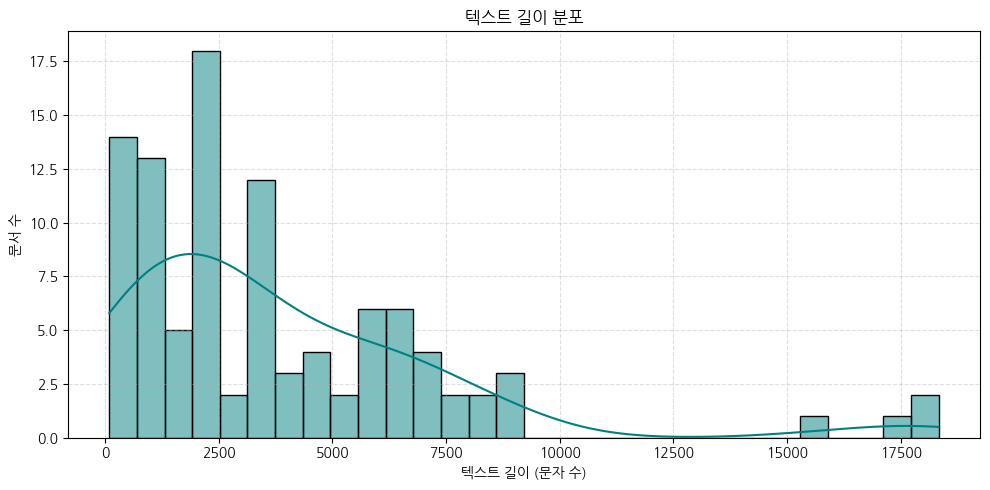

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(df['텍스트_길이'], bins=30, kde=True, color='teal')
plt.title('텍스트 길이 분포')
plt.xlabel('텍스트 길이 (문자 수)')
plt.ylabel('문서 수')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### **기관별 공고 수**

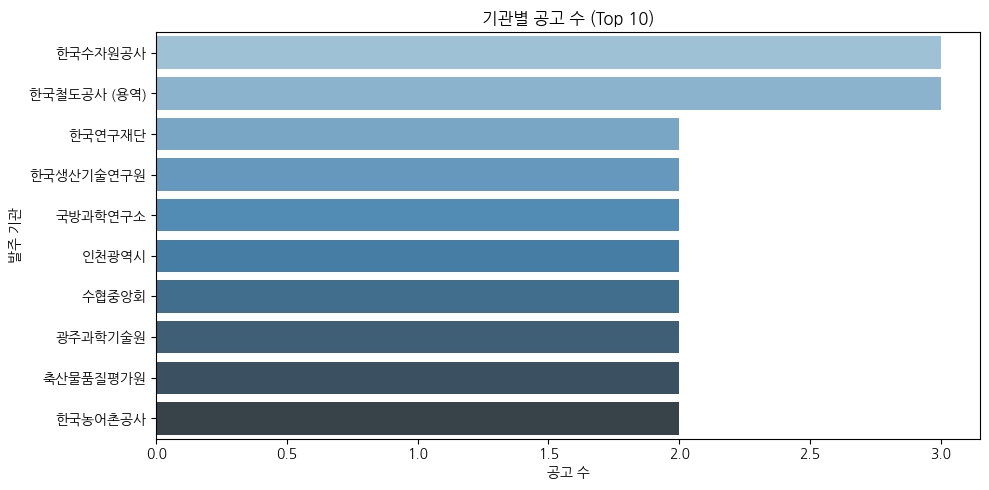

In [22]:
top_orgs = df['발주 기관'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_orgs.values, y=top_orgs.index, palette="Blues_d")
plt.title("기관별 공고 수 (Top 10)")
plt.xlabel("공고 수")
plt.ylabel("발주 기관")
plt.tight_layout()
plt.show()

### **월별 공고 수 추이**

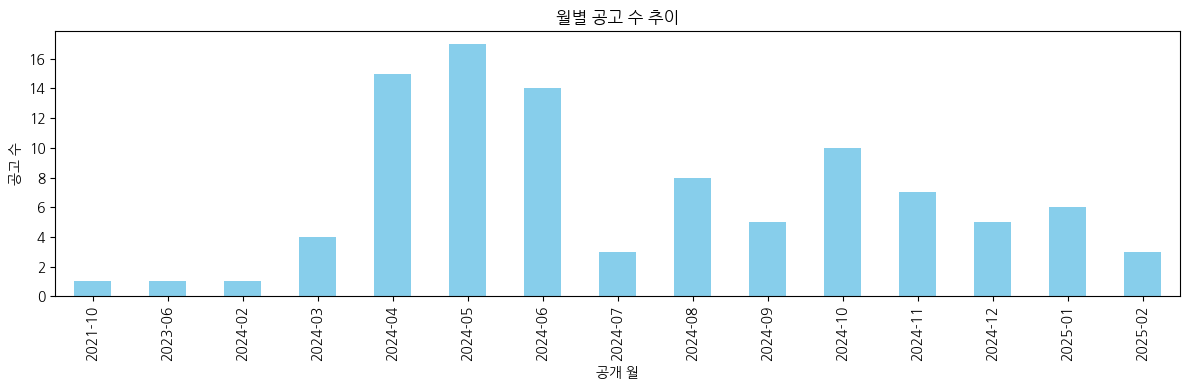

In [23]:
# 날짜 형식 변환
df['공개 일자'] = pd.to_datetime(df['공개 일자'], errors='coerce')

# 월별 추이
monthly = df['공개 일자'].dt.to_period("M").value_counts().sort_index()
monthly.plot(kind='bar', figsize=(12, 4), color='skyblue')
plt.title("월별 공고 수 추이")
plt.xlabel("공개 월")
plt.ylabel("공고 수")
plt.tight_layout()
plt.show()

### **분기별 공고 수 추이**

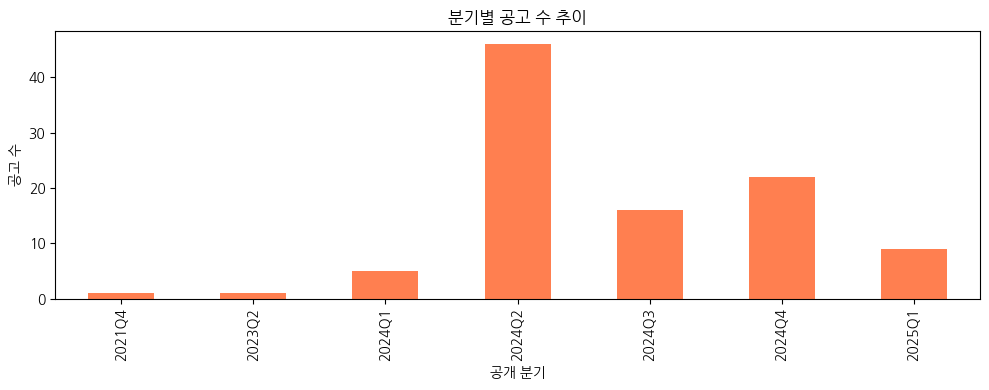

In [24]:
quarterly = df['공개 일자'].dt.to_period("Q").value_counts().sort_index()

quarterly.plot(kind='bar', figsize=(10, 4), color='coral')
plt.title("분기별 공고 수 추이")
plt.xlabel("공개 분기")
plt.ylabel("공고 수")
plt.tight_layout()
plt.show()

### **사업 금액 분포 (로그 변환 포함)**
- 사업 금액은 최대 약 140억 원까지 분포

- 10억 원 이하 규모의 사업이 다수를 차지하며, 수십억 규모 사업은 상대적으로 적음

- 로그 스케일 분포에서는 log(금액) ≈ 20 부근에 데이터가 집중되어 있음
→ 실제 금액으로는 약 4~5억 원 규모 사업이 가장 흔함

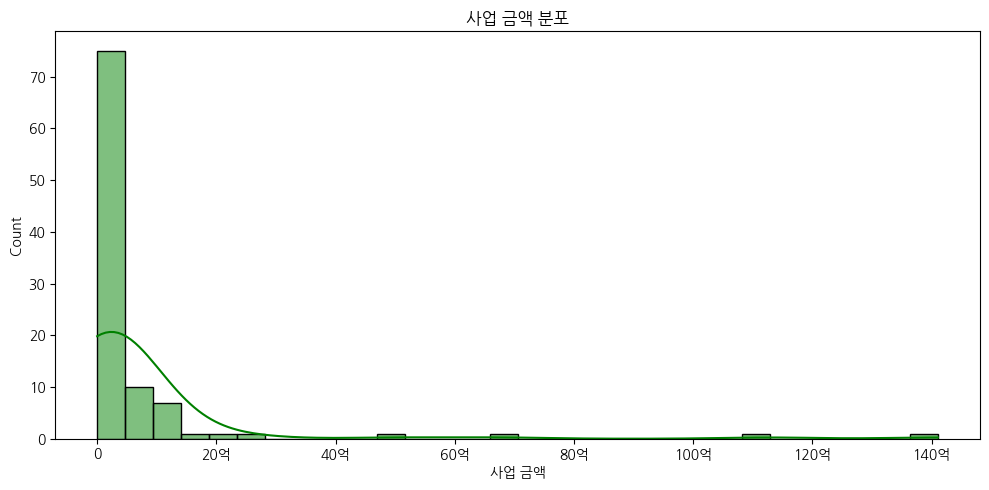

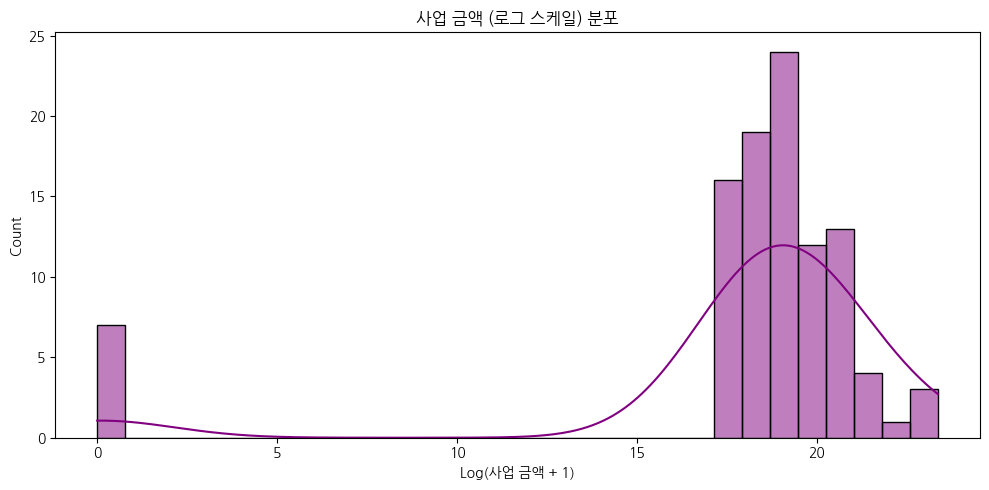

In [7]:
# 결측 제거
df_amount = df[df['사업 금액'].notnull()]

# 억 단위 포맷 함수
def format_billions(x, pos):
    return f"{int(x / 1e8)}억" if x >= 1e8 else f"{int(x):,}"

# 일반 스케일 분포 (억 단위 표시)
plt.figure(figsize=(10, 5))
sns.histplot(df_amount['사업 금액'], bins=30, kde=True, color='green')
plt.title("사업 금액 분포")
plt.xlabel("사업 금액")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_billions))
plt.tight_layout()
plt.show()

# 로그 분포
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df_amount['사업 금액']), bins=30, kde=True, color='purple')
plt.title("사업 금액 (로그 스케일) 분포")
plt.xlabel("Log(사업 금액 + 1)")
plt.tight_layout()
plt.show()

### **기관별 평균 사업 금액 (Top 10)**

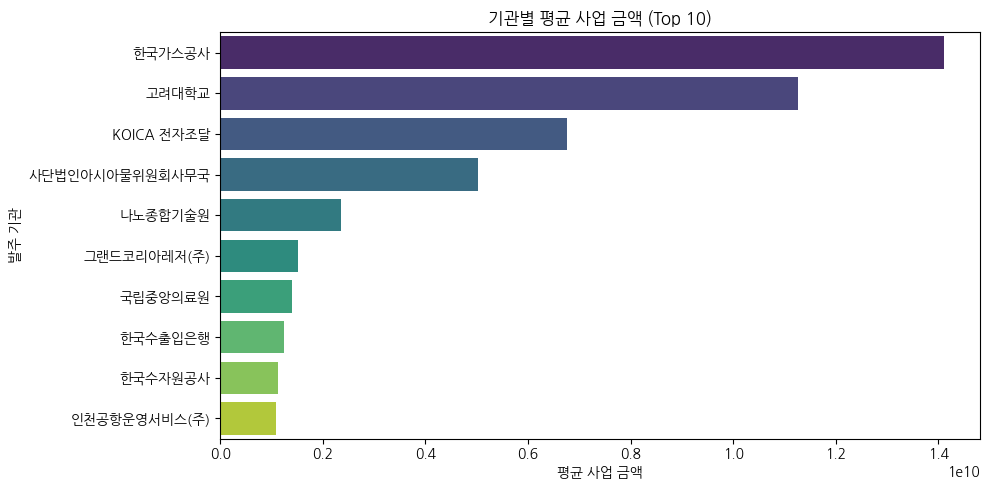

In [26]:
top_mean_budget = df.groupby('발주 기관')['사업 금액'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_mean_budget.values, y=top_mean_budget.index, palette="viridis")
plt.title("기관별 평균 사업 금액 (Top 10)")
plt.xlabel("평균 사업 금액")
plt.ylabel("발주 기관")
plt.tight_layout()
plt.show()

### **응찰 준비 기간 분포(일 단위)**

In [29]:
# 날짜 변환
df['공개 일자'] = pd.to_datetime(df['공개 일자'])
df['입찰 참여 시작일'] = pd.to_datetime(df['입찰 참여 시작일'], errors='coerce')
df['입찰 참여 마감일'] = pd.to_datetime(df['입찰 참여 마감일'], errors='coerce')

# 응찰 준비 기간
df['응찰 기간 (일)'] = (df['입찰 참여 마감일'] - df['공개 일자']).dt.days

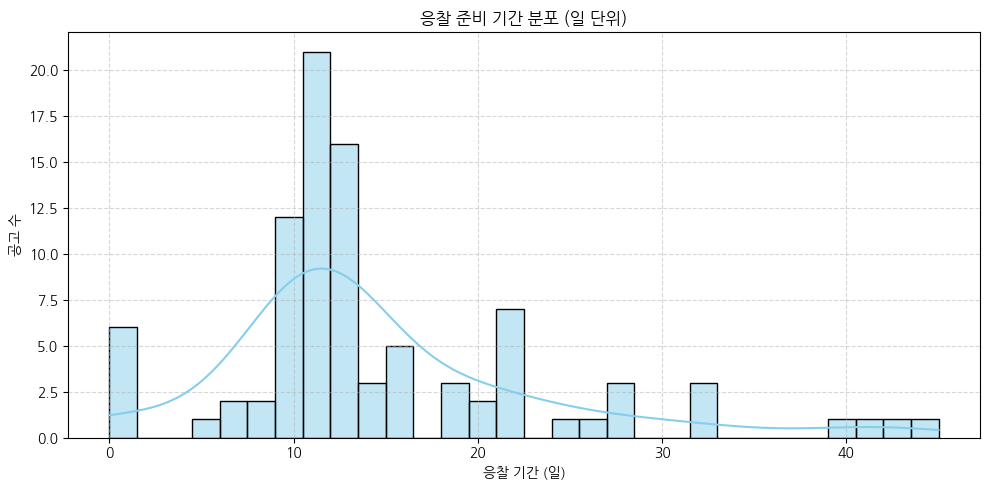

In [30]:
plt.figure(figsize=(10, 5))
sns.histplot(df['응찰 기간 (일)'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('응찰 준비 기간 분포 (일 단위)')
plt.xlabel('응찰 기간 (일)')
plt.ylabel('공고 수')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **텍스트 워드클라우드**

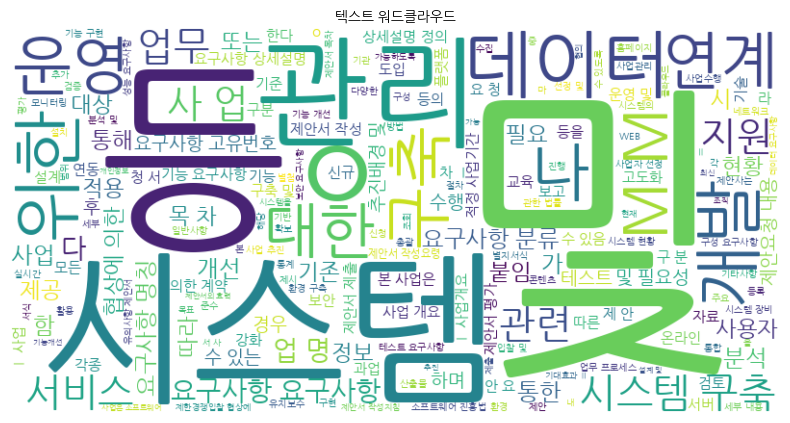

In [36]:
font_path = fm.findfont("NanumGothic")

text_data = ' '.join(df['텍스트'].dropna().tolist())
wordcloud = WordCloud(
    font_path=font_path,          # 한글 폰트 경로 지정
    background_color='white',
    width=800,
    height=400
).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('텍스트 워드클라우드', fontproperties=fm.FontProperties(fname=font_path))
plt.show()